# *k*-means clustering

Up until now, we have only examined *supervised* machine learning (ML), in which we provide labeled training data for the algorithm. *k*-means clustering is the first *unsupervised* ML algorithm that we have dealt with: we provide the algorithm with a set of $n$ data points and tell the algorithm that we want that data partitioned into $k$ clusters that provide the best separation between clusters. 

The *k*-means algorithm randomly assigns $k$ *centroids* (or geometric centers of subsets of the dataset as measured through [Euclidean distance](http://mathworld.wolfram.com/Distance.html)) to the data and then iteratively moves those centroids around the feature space until it converges on an arrangement of the centroids the minimizes the variance within the clusters.

![SegmentLocal|20%](Images/K-means_convergence.gif "segment")

(Image courtesy of [Wikimedia Commons](https://en.wikipedia.org/wiki/File:K-means_convergence.gif) and is distributed under the terms of the [GNU Free Documentation License](https://en.wikipedia.org/wiki/GNU_Free_Documentation_License).)

> **Learning objective:** By the end of this section, you should have a basic understanding of the kinds of results the *k*-means algorithm can produce and have some idea about how you can interpret those results.

## Load and prepare data

To illustrate *k*-means clustering in action, we'll use the familiar [U.S. Department of Agriculture National Nutrient Database for Standard Reference](https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/nutrient-data-laboratory/docs/usda-national-nutrient-database-for-standard-reference/) dataset.(Note that the path name is case sensitive.)

In [1]:
import pandas as pd
df = pd.read_csv('Data/USDA-nndb-combined.csv', encoding='latin_1')

In [2]:
df.head()

,NDB_No,FoodGroup,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),...,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT",15.87,717.0,0.85,81.11,2.11,0.06,0.0,...,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT",16.72,718.0,0.49,78.30,1.62,2.87,0.0,...,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",0.24,876.0,0.28,99.48,0.00,0.00,0.0,...,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,0.0
3,1004,Dairy and Egg Products,"CHEESE,BLUE",42.41,353.0,21.40,28.74,5.11,2.34,0.0,...,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,0.0
4,1005,Dairy and Egg Products,"CHEESE,BRICK",41.11,371.0,23.24,29.68,3.18,2.79,0.0,...,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",0.0


Because the *k*-means algorithm works with the Euclidean distance between data points, we need to once again separate out our descriptive from our numeric features (while saving the descriptive features for later use).

In [3]:
desc_df = df.iloc[:, [0, 1, 2]+[i for i in range(50,54)]]
desc_df.set_index('NDB_No', inplace=True)
desc_df.head()

,FoodGroup,Shrt_Desc,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
NDB_No,,,,,,
1001,Dairy and Egg Products,"BUTTER,WITH SALT","1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1002,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT","1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",1 tbsp,205.0,1 cup,0.0
1004,Dairy and Egg Products,"CHEESE,BLUE",1 oz,17.0,1 cubic inch,0.0
1005,Dairy and Egg Products,"CHEESE,BRICK","1 cup, diced",113.0,"1 cup, shredded",0.0


In [4]:
nutr_df = df.iloc[:, :-5]
nutr_df = nutr_df.drop(['FoodGroup', 'Shrt_Desc'], axis=1)
nutr_df.set_index('NDB_No', inplace=True)
nutr_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_D_IU,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0


The correlations that we have seen before in this dataset are still an issue here.

|   | column            | row               | corr |
|--:|------------------:|------------------:|-----:|
| 0 | Folate\_Tot\_(µg) | Folate\_DFE\_(µg) | 0.98 |
| 1 | Folic\_Acid\_(µg) | Folate\_DFE\_(µg) | 0.95 |
| 2 | Folate\_DFE\_(µg) | Folate\_Tot\_(µg) | 0.98 |
| 3 | Vit\_A\_RAE       | Retinol\_(µg)     | 0.99 |
| 4 | Retinol\_(µg)     | Vit\_A\_RAE       | 0.99 |
| 5 | Vit\_D\_µg        | Vit\_D\_IU        | 1    |
| 6 | Vit\_D\_IU        | Vit\_D\_µg        | 1    |

Before dropping anything from the `df` `DataFrame`, however, let's take a quick look at these correlations visually. Let's start with `Folate_Tot_(µg)` and `Folate_DFE_(µg)`.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 54 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NDB_No             8989 non-null   int64  
 1   FoodGroup          8618 non-null   object 
 2   Shrt_Desc          8790 non-null   object 
 3   Water_(g)          8789 non-null   float64
 4   Energ_Kcal         8790 non-null   float64
 5   Protein_(g)        8790 non-null   float64
 6   Lipid_Tot_(g)      8790 non-null   float64
 7   Ash_(g)            8465 non-null   float64
 8   Carbohydrt_(g)     8790 non-null   float64
 9   Fiber_TD_(g)       8196 non-null   float64
 10  Sugar_Tot_(g)      6958 non-null   float64
 11  Calcium_(mg)       8442 non-null   float64
 12  Iron_(mg)          8646 non-null   float64
 13  Magnesium_(mg)     8051 non-null   float64
 14  Phosphorus_(mg)    8211 non-null   float64
 15  Potassium_(mg)     8364 non-null   float64
 16  Sodium_(mg)        8707 

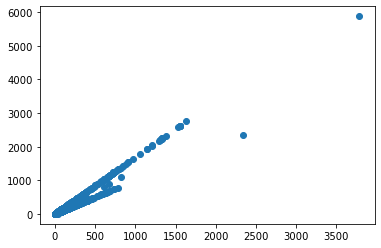

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(df['Folate_Tot_(Âµg)'], df['Folate_DFE_(Âµg)'])

This is a dramatic correlation!

> **Troubleshooting note:** Despite specifying Latin_1 encoding when we read in the dataset from the CSV file, character corruption can still occur. If the plt.scatter call above fails, try this code instead: `plt.scatter(df['Folate\_Tot\_(Âµg)'], df['Folate\_DFE\_(Âµg)'])`

> **Exercise**
>
> In the code cell below, run a scatterplot of another correlative pair of features from this dataset. (**Hint:** You only need to run the `plt.scatter` function with new parameters.)

Let's drop `Folate_DFE_(µg)`, `Vit_A_RAE`, and `Vit_D_IU` from `df` in order to eliminate these problematic correlations. The *k*-means algorithm also doesn't work with `NaN` values, so we will also have to drop those.

In [8]:
nutr_df.drop(['Folate_DFE_(Âµg)', 'Vit_A_RAE', 'Vit_D_IU'], 
        inplace=True, axis=1)
nutr_df = nutr_df.dropna()
nutr_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Beta_Crypt_(Âµg),Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,0.0,0.0,0.0,2.32,0.0,7.0,51.368,21.021,3.043,215.0
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,6.0,0.0,13.0,1.37,0.0,4.6,45.390,19.874,3.331,225.0
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,0.0,0.0,0.0,2.80,0.0,8.6,61.924,28.732,3.694,256.0
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.0,0.0,0.0,0.25,0.5,2.4,18.669,7.778,0.800,75.0
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.0,0.0,0.0,0.26,0.5,2.5,18.764,8.598,0.784,94.0


> **Troubleshooting note:** Again, if the read_csv() function did not read in the µ (mu) symbol correctly and the drop() method call above fails, try this code instead: `nutr_df.drop(['Folate\_DFE\_(Âµg)', 'Vit\_A\_RAE', 'Vit\_D\_IU'], inplace=True, axis=1)`

Because the *k*-means algorithm will be calculating the Euclidean distances between data points and centroids, we need to ensure that all of the numeric features in our dataset use compatible units; we don't want to try and calculate distances between units of mass like grams and units of energy like kilocalories. As we will with principal component analysis (PCA), we will use scikit-learn's [`StandardScaler()` function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to center the data around each feature's mean and transform each feature to have a standard deviation of 1.

In [9]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(nutr_df)

## Fitting the *k*-means clustering model

We are now ready to import *k*-means clustering algorithm.

In [10]:
from sklearn.cluster import KMeans

While we can use any number of clusters that we wish, we will initially use three clusters as a convenient number for an initial exploration of k-means clustering.

In [11]:
kmeansmodel = KMeans(n_clusters=3, random_state=13)
kmeansmodel.fit(X)

KMeans(n_clusters=3, random_state=13)

> **Question**
>
> Given what you have learned in this course thus far, what role does our declaration of the `random_state` above play in the `KMeans()` function?

Let's take a look at the labels for our clusters.

> **Question**
>
> Given what you know about Python zero-indexing and the number of clusters we selected, what labels do you expect to see?

In [12]:
kmeansmodel.labels_

array([1, 1, 1, ..., 1, 2, 2], dtype=int32)

As expected, our labels for the different clusters are `0`, `1`, and `2`.

Let's examine the distribution of data points among the clusters.

In [13]:
pd.value_counts(kmeansmodel.labels_)

2    2434
1     807
0      76
dtype: int64

You might also check various cluster stats for comparison of the clusters.

We will want to access these labels later on, so let's add them to our `DataFrame`.

In [14]:
nutr_df['Cluster'] = kmeansmodel.labels_
nutr_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),Cluster
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,0.0,0.0,2.32,0.0,7.0,51.368,21.021,3.043,215.0,1
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,0.0,13.0,1.37,0.0,4.6,45.390,19.874,3.331,225.0,1
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,0.0,0.0,2.80,0.0,8.6,61.924,28.732,3.694,256.0,1
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.0,0.0,0.25,0.5,2.4,18.669,7.778,0.800,75.0,1
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.0,0.0,0.26,0.5,2.5,18.764,8.598,0.784,94.0,1


> **Takeaway:** Because data naturally clusters, we should not expect the clusters to be the same size.

## Interpreting the *k*-means clustering model

What sorts of foods populate the different clusters? We'll examine that question in greater depth later on, but we can get some sense of our clusters just by looking at the mean values for each of them.

In [15]:
nutr_df.groupby('Cluster').mean()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Beta_Crypt_(Âµg),Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
Cluster,,,,,,,,,,,,,,,,,,,,,
0,12.479211,335.394737,13.170921,5.829211,4.097105,64.437763,9.122368,19.649868,368.355263,21.796842,...,131.434211,6.289474,582.342105,8.257895,2.934211,60.148684,1.653000,1.731184,1.656461,45.434211
1,13.287113,422.845105,10.786543,20.262701,3.395576,52.099356,4.495167,20.853371,177.353160,3.323804,...,4.551425,76.423792,101.524164,2.333680,0.450062,11.100000,6.626726,7.414724,4.675971,22.897150
2,71.824910,137.229663,12.221159,5.733439,1.258505,9.005148,1.005957,3.602383,40.699260,1.291056,...,6.814708,175.988907,258.121200,0.427802,0.478266,14.829622,2.044058,2.263873,0.801156,43.499178


We can quickly see that cluter 2 encompasses fatty foods (high `Lipid_Tot_(g)` values). Clusters 0 and 1 have similar mean protein and lipid amounts; an easy-to-see differentiation between those clusters is their relative carbohydrate and sugar levels, with those in cluster 1 being significantly higher than those in cluster 0.

We can look at these high-level differences in a little more detail using the `describe()` method, though, honestly, given the size of the `DataFrame`, this is a little cumbersome.

In [16]:
nutr_df.groupby('Cluster').describe()

Water_(g)                                                          \
            count       mean        std  min    25%    50%     75%    max   
Cluster                                                                     
0            76.0  12.479211  20.950263  1.2   2.60   3.88   9.095  76.46   
1           807.0  13.287113  13.940987  0.0   3.00   7.18  20.760  59.55   
2          2434.0  71.824910  15.405493  0.0  61.45  71.80  85.655  99.90   

        Energ_Kcal              ... FA_Poly_(g)         Cholestrl_(mg)  \
             count        mean  ...         75%     max          count   
Cluster                         ...                                      
0             76.0  335.394737  ...     1.99100   8.006           76.0   
1            807.0  422.845105  ...     5.44750  57.740          807.0   
2           2434.0  137.229663  ...     0.92825  12.993         2434.0   

                                                              
              mean         std  min  25%   50%   75%     max  
Cluster                                                       
0        45.434211  128.789889  0.0  0.0   0.0   0.0   563.0  
1        22.897150  108.563565  0.0  0.0   0.0  12.0  2307.0  
2        43.499178   93.845932  0.0  0.0  12.0  76.0  3100.0  

[3 rows x 344 columns]

We can also predict the label for new or hypothetical observations. Let's provide the nutritional details for Gjetost cheese and see which cluster our model places it in. (Gjetost cheese is one of our discarded entries from the original `DataFrame` with `NaN` values imputed below.)

In [17]:
newcase = [[1021,
            13.44,
            466.0,
            9.65,
            29.51,
            4.75,
            42.65,
            0.0,
            1.50,
            400.0,
            0.52,
            70.0,
            444.0,
            1409.0,
            600.0,
            1.14,
            0.08,
            0.04,
            14.5,
            0.0,
            0.315,
            1.382,
            0.813,
            3.351,
            0.271,
            5.0,
            0.0,
            5.0,
            15.4,
            2.42,
            1113.0,
            334.0,
            0,
            20,
            0,
            0.5,
            22,
            2.4,
            19.16,
            7.879,
            0.938,
            94.0,
            28.35]]

In [18]:
kmeansmodel.predict(newcase)

array([0], dtype=int32)

The output indicates that Gjetost cheese falls under cluster 1.

> **Exercise**
>
> Now go back up and alter the values for Gjetost cheese  in the `newcase` array above to see what it takes to get that array classified into cluster 0 or cluster 2.

We can also see the actual coordinate values for cluster centroids.

In [19]:
kmeansmodel.cluster_centers_

array([[-1.45636064e+00,  7.96327427e-01,  1.15255072e-01,
        -2.62205139e-01,  6.29272297e-01,  1.64668962e+00,
         1.66530913e+00,  7.44893167e-01,  1.15185802e+00,
         4.17985293e+00,  1.54027742e+00,  6.00361238e-01,
         6.61902755e-01,  1.30076983e-01,  1.99009205e+00,
         1.72899583e+00,  1.11943625e+00,  1.46259578e-01,
         1.19320695e+00,  2.85744315e+00,  3.90654671e+00,
         3.79855794e+00,  2.89431951e+00,  4.11122461e+00,
         4.12892280e+00,  4.16761288e+00,  1.43534529e+00,
         2.45089614e-01,  2.62671104e+00,  2.03197512e+00,
         3.17249585e+00,  5.42194488e-01,  6.52709032e-01,
         9.37151523e-01, -1.00555752e-01,  2.76383556e-01,
         2.07139695e+00,  1.21427309e+00,  5.90665442e-01,
        -2.77812581e-01, -3.02230366e-01, -2.70202940e-02,
         6.98109660e-02],
       [-1.42946341e+00,  1.35731497e+00, -9.99405482e-02,
         8.37541996e-01,  4.33387014e-01,  1.18152396e+00,
         5.77168533e-01,  8.22

Remember that there is a method to this wall of numbers. Each coordinate is a point in 43-dimensional space, so each centroid is represented by an array of 43 values.

Let's now add back in our descriptive features so that we can see which food groups are in our clusters.

In [20]:
merged_df = nutr_df.join(desc_df)
merged_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),Cluster,FoodGroup,Shrt_Desc,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,21.021,3.043,215.0,1,Dairy and Egg Products,"BUTTER,WITH SALT","1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,19.874,3.331,225.0,1,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT","1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,28.732,3.694,256.0,1,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",1 tbsp,205.0,1 cup,0.0
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,7.778,0.800,75.0,1,Dairy and Egg Products,"CHEESE,BLUE",1 oz,17.0,1 cubic inch,0.0
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,8.598,0.784,94.0,1,Dairy and Egg Products,"CHEESE,BRICK","1 cup, diced",113.0,"1 cup, shredded",0.0


Now we can look at the value counts for the different food groups in our clusters.

In [21]:
merged_df.loc[nutr_df['Cluster'] == 0]['FoodGroup'].value_counts()

Breakfast Cereals                    40
Snacks                                6
Poultry Products                      5
Vegetables and Vegetable Products     5
Spices and Herbs                      5
Baby Foods                            5
Beverages                             3
Beef Products                         3
Sausages and Luncheon Meats           1
Baked Products                        1
Cereal Grains and Pasta               1
Name: FoodGroup, dtype: int64

> **Question**
>
> Look back over the Python in the code cell above. Does the syntax make sense? If not, review the documentation for [`pandas.DataFrame.loc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) and [`pandas.Series.value_counts`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html).

> **Exercise**
>
> Now find the `FoodGroup` value counts for clusters 1 and 2.

In [22]:
merged_df.loc[nutr_df['Cluster'] == 1]['FoodGroup'].value_counts()

Baked Products                       162
Sweets                               109
Snacks                                77
Dairy and Egg Products                61
Cereal Grains and Pasta               53
Nut and Seed Products                 48
Legumes and Legume Products           37
Breakfast Cereals                     35
Fats and Oils                         31
Baby Foods                            29
Beverages                             27
Pork Products                         13
Soups, Sauces, and Gravies            12
Spices and Herbs                      11
Sausages and Luncheon Meats           11
Fruits and Fruit Juices               11
Vegetables and Vegetable Products     10
Poultry Products                      10
Fast Foods                            10
Meals, Entrees, and Side Dishes        7
Lamb, Veal, and Game Products          5
Beef Products                          3
Restaurant Foods                       3
Finfish and Shellfish Products         2
Name: FoodGroup,

In [23]:
merged_df.loc[nutr_df['Cluster'] == 2]['FoodGroup'].value_counts()

Beef Products                          421
Vegetables and Vegetable Products      412
Pork Products                          194
Fruits and Fruit Juices                165
Poultry Products                       145
Baby Foods                             108
Finfish and Shellfish Products         108
Dairy and Egg Products                 104
Soups, Sauces, and Gravies              97
Beverages                               93
Baked Products                          77
Lamb, Veal, and Game Products           68
Legumes and Legume Products             68
Sweets                                  58
Fast Foods                              57
Sausages and Luncheon Meats             52
Meals, Entrees, and Side Dishes         32
Cereal Grains and Pasta                 26
Restaurant Foods                        20
Fats and Oils                           20
Breakfast Cereals                        9
Spices and Herbs                         7
Nut and Seed Products                    3
American In

Some of the entries in our clusters makes sense and others look kind of like the contents of a grab bag. Part of the reason for this is that the *k*-means algorithm has to draw rather arbitrary boundaries between clusters; there will be a lot of entries in all clusters that are right on the edge and could reasonably belong to two (or more) clusters. To reduce some of this noise, we can sort these by distance from centroid of the respective clusters and look at the entries closest to the centroids.

In [24]:
import numpy as np

distances = kmeansmodel.fit_transform(X)
merged_df['Distance'] = np.min(distances, axis=1)
merged_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,FA_Poly_(g),Cholestrl_(mg),Cluster,FoodGroup,Shrt_Desc,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct,Distance
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,3.043,215.0,1,Dairy and Egg Products,"BUTTER,WITH SALT","1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0,11.023925
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,3.331,225.0,1,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT","1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0,10.082188
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,3.694,256.0,1,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",1 tbsp,205.0,1 cup,0.0,13.831696
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.800,75.0,1,Dairy and Egg Products,"CHEESE,BLUE",1 oz,17.0,1 cubic inch,0.0,4.592396
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.784,94.0,1,Dairy and Egg Products,"CHEESE,BRICK","1 cup, diced",113.0,"1 cup, shredded",0.0,4.909087


> **Questions**
>
> 1. Why is it only necessary to find the minimum distance to the three centroids for a given data point (`np.min`)?
> 2. What role does the `axis=1` parameter play in the `np.min()` function?

We can now sort `FoodGroup` value counts by distance to the cluster's centroid, which can make the lists of principal food types in each cluster more intuitive.

In [25]:
merged_df.loc[nutr_df['Cluster'] == 0].sort_values(by='Distance')['FoodGroup'][:500].value_counts()

Breakfast Cereals                    40
Snacks                                6
Poultry Products                      5
Baby Foods                            5
Vegetables and Vegetable Products     5
Spices and Herbs                      5
Beef Products                         3
Beverages                             3
Sausages and Luncheon Meats           1
Baked Products                        1
Cereal Grains and Pasta               1
Name: FoodGroup, dtype: int64

> **Question**
>
> Look back over the Python in the code cell above. Does the syntax make sense? If not, review the documentation for [`pandas.DataFrame.sort_values`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) and [slicing ranges in pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#slicing-ranges).

> **Exercise**
>
> Now find the sorted `FoodGroup` value counts for clusters 1 and 2. (**Note:** Due to the differing sizes of the clusters, try a variety of ranges for your slices.)

In [26]:
merged_df.loc[nutr_df['Cluster'] == 1].sort_values(by='Distance')['FoodGroup'][:30].value_counts()

Baked Products    21
Snacks             7
Name: FoodGroup, dtype: int64

In [27]:
merged_df.loc[nutr_df['Cluster'] == 2].sort_values(by='Distance')['FoodGroup'][:200].value_counts()

Poultry Products                     24
Beef Products                        22
Finfish and Shellfish Products       17
Dairy and Egg Products               17
Baby Foods                           16
Meals, Entrees, and Side Dishes      12
Pork Products                        12
Vegetables and Vegetable Products    10
Restaurant Foods                      9
Sausages and Luncheon Meats           8
Legumes and Legume Products           8
Fast Foods                            6
Sweets                                6
Lamb, Veal, and Game Products         6
Soups, Sauces, and Gravies            5
Beverages                             2
Cereal Grains and Pasta               2
Name: FoodGroup, dtype: int64

> **Takeaway:** Even without subject-matter expertise, we can gain insights of varying depth about the clusters.

## Visualizing the *k*-means clustering model

Similar to the situation with PCA, we can create visualizations of our clusters, but visualization is crude at best when it has been projected down through so many dimensions. That said, even trying to project from 43 dimensions down to 3 dimensions, noticeable patterns persist. To perform this visualization, we will first need to import the Axes3D module.

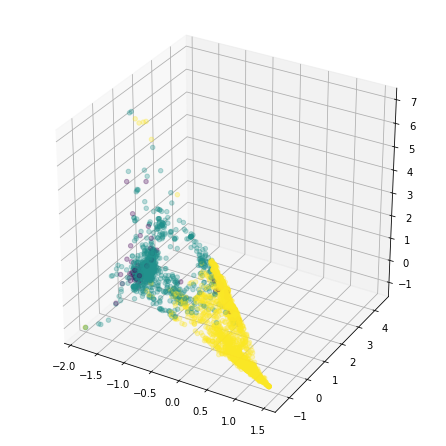

In [28]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
C = kmeansmodel.cluster_centers_
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=kmeansmodel.labels_, alpha=0.3)

plt.show()

> **Takeaway:** Two observations:
> 1. Notice that there is no hard boundary visible between the purple and yellow clusters. The boundary is there, but, because it's a higher-dimensional hyperplane, it gets smeared across three dimensional space.
> 2. Note also that points from the light blue cluster are scattered across the plot. This is also an artifact of the clusters projection down from 43 dimensions to 3.

## Determining the number of clusters to use

You might have noticed that we manually determined the number $k$, the number of clusters, earlier in this section. We assigned `n_clusters_ = 3` in the model. But is 3 the right number of clusters for this dataset?

In practice, determining the correct number of clusters can require a lot on domain knowledge and data interpretation. However, we can use the elbow method as a rough heuristic for determining the number of clusters to use, even absent any domain knowledge.

In the elbow method, we plot the within-cluster sum of squares (WCSS, a measure of the variability of the observations within each cluster) against different values of $k$. Similar to the scree graph we used with PCA, we are looking for the value of $k$ near where WCSS begins to flatten out and form an elbow.

In [29]:
WCSS = []
for num in range(1, 12):
    kmeans = KMeans(n_clusters = num,  random_state = 50)
    kmeans.fit(X)
    WCSS.append(kmeans.inertia_)

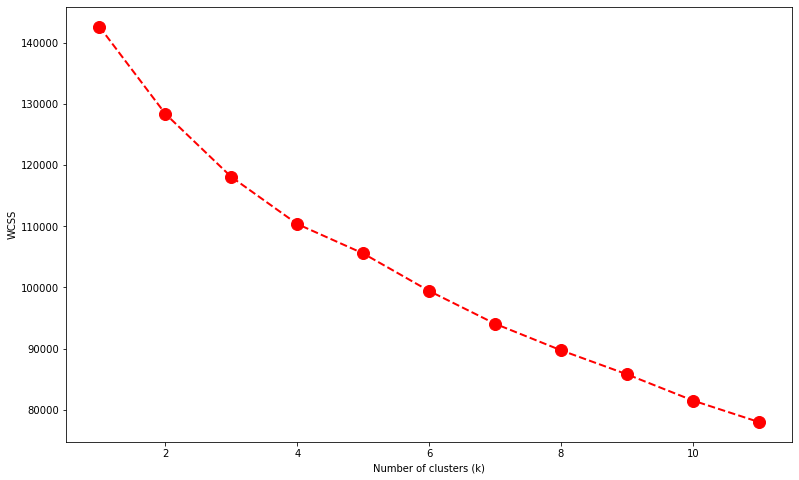

In [30]:
plt.figure(figsize=(13, 8))
    
plt.plot(range(1, 12), WCSS,'ro--',linewidth=2, markersize=12)
# plt.title('ELBOW METHOD')
plt.rcParams.update({'font.size': 14})
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

> **Takeaway:** Ideally, we would want to see a more pronounced elbow. One could make the case for the elbow being at $k=5$ — or at $k=8$ or $k=10$. And some datasets do produce a distinct elbow. However, real-world data is inherently messy, and there is no perfect way to evaluate *k*-means models apart from domain expertise and rigorous analysis.

## Running k-means clustering outside of Jupyter notebooks

Python code does not have to reside in notebooks. Simple programs can provide a useful tool for investigating your data. To see this in action, open the program [k-Means.py](https://github.com/daniel-dc-cd/data_science/blob/master/daily_materials/ml_kmeans_nb_regression/k-Means.py) in the GitHub repository for this course.

The program is largely the code from earlier in this notebook. Now run k-Means.py from the command line interface on your local computer. It will ask for the number of clusters and the file path for the USDA dataset that you have been using in this section.

> **Exercise**
>
> Run k-Means.py using several different numbers for k (including those indicated by the WCSS graph above). Do they provide intuitive groupings of food groups?

> **Takeaway:** One reason for Python’s popularity in the data-science community is its extreme flexibility. It provides numerous tools that data scientists can use in a variety of ways.

## *k*-means and PCA

What if we went with $k=5$ instead of $k=3$? Would the contents of our clusters align with the components we identified in the [PCA Notebook?]() We did, after all, divide the National Nutrient Database into five components in that section using PCA.

It's a seductive idea, but an incorrect one. Let's examine *why* it's incorrect; we'll start by re-fitting our *k*-means model on five clusters. (Remember that we defined earlier in this section `X = StandardScaler().fit_transform(nutr_df)`.)

In [31]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X)
nutr_df['Cluster'] = km.labels_
nutr_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),Cluster
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,0.0,0.0,2.32,0.0,7.0,51.368,21.021,3.043,215.0,1
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,0.0,13.0,1.37,0.0,4.6,45.390,19.874,3.331,225.0,1
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,0.0,0.0,2.80,0.0,8.6,61.924,28.732,3.694,256.0,1
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.0,0.0,0.25,0.5,2.4,18.669,7.778,0.800,75.0,2
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.0,0.0,0.26,0.5,2.5,18.764,8.598,0.784,94.0,2


In [32]:
dists = km.fit_transform(X)
merged_df = nutr_df.join(desc_df)
merged_df['Distance'] = np.min(dists, axis=1)
merged_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,FA_Poly_(g),Cholestrl_(mg),Cluster,FoodGroup,Shrt_Desc,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct,Distance
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,3.043,215.0,1,Dairy and Egg Products,"BUTTER,WITH SALT","1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0,9.509794
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,3.331,225.0,1,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT","1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0,8.753474
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,3.694,256.0,1,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",1 tbsp,205.0,1 cup,0.0,11.625892
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.800,75.0,2,Dairy and Egg Products,"CHEESE,BLUE",1 oz,17.0,1 cubic inch,0.0,4.368372
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.784,94.0,2,Dairy and Egg Products,"CHEESE,BRICK","1 cup, diced",113.0,"1 cup, shredded",0.0,4.698566


We have now defined `merged_df` for $k=5$. Let's now extract the two features we will want to combine with our PCA results: `Cluster` and `FoodGroup`.

In [33]:
cluster_df = merged_df[['Cluster', 'FoodGroup']]
cluster_df.head()

,Cluster,FoodGroup
NDB_No,,
1001,1,Dairy and Egg Products
1002,1,Dairy and Egg Products
1003,1,Dairy and Egg Products
1004,2,Dairy and Egg Products
1005,2,Dairy and Egg Products


Let's now run PCA on this dataset and join `Cluster` and `FoodGroup` to the results.

In [34]:
from sklearn.decomposition import PCA

fit = PCA()
pca = fit.fit_transform(X)
pca_df = pd.DataFrame(pca[:, :5], index=nutr_df.index)
pca_df = pca_df.join(cluster_df)
pca_df.rename(columns={0:'c1', 1:'c2', 2:'c3', 3:'c4', 4:'c5'}, 
              inplace=True)
pca_df.head()

,c1,c2,c3,c4,c5,Cluster,FoodGroup
NDB_No,,,,,,,
1001,1.210730,-7.749161,0.011221,2.814936,-3.573719,1,Dairy and Egg Products
1002,1.054329,-7.239046,0.016543,2.610281,-3.424977,1,Dairy and Egg Products
1003,1.920274,-9.822701,0.020957,3.601209,-5.035544,1,Dairy and Egg Products
1004,0.859770,-2.428186,-0.621847,0.928657,0.951062,2,Dairy and Egg Products
1005,0.602773,-2.724407,-0.610201,1.134215,0.780761,2,Dairy and Egg Products


Now that we have the PCA results in a `DataFrame`, let's sort them by $c_1$ and see how the cluster labels break down among the top 500 results.

In [35]:
pca_df.sort_values(by='c1')['Cluster'][:500].value_counts()

0    500
Name: Cluster, dtype: int64

$c_1$ proved to have pretty close overlap with cluster 2. What about $c_2$?

In [36]:
pca_df.sort_values(by='c2')['Cluster'][:500].value_counts()

3    230
2    151
1    114
0      5
Name: Cluster, dtype: int64

Here, the results are decidedly more mixed. But you can get a sense of how *k*-means clusters and PCA components do (and don't) overlap by changing the number of entries in the slice.

> **Exercise**
>
> Evaluate the extent to which *k*-means clusters overlap with PCA components for $c_3$, $c_4$, and $c_5$. You might also want to adjust the size of slices that you take (more or less than 500) in order to see what effect that has on your results.

In [37]:
pca_df.sort_values(by='c3')['Cluster'][:500].value_counts()

2    484
4     15
1      1
Name: Cluster, dtype: int64

In [38]:
pca_df.sort_values(by='c4')['Cluster'][:500].value_counts()

3    399
0     55
4     46
Name: Cluster, dtype: int64

In [39]:
pca_df.sort_values(by='c5')['Cluster'][:500].value_counts()

3    247
1     86
0     69
4     55
2     43
Name: Cluster, dtype: int64

> **Takeaway:** While there can be some overlap between PCA and *k*-means, you should never conflate the two analytical techniques in your mind. *k*-means partitions a dataset into discrete clusters while PCA identifies components of the feature space of a dataset that convey the most information about the structure of the dataset.